In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Libraries for Text data
import spacy
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Read the dataset
data = pd.read_csv('hotel_reviews.csv')
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
data1 = data.copy()
data1.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


## Attributes based on Reviews (**Cleaned Data**)

**Removing Stop Words, numbers and puntuation marks**

In [20]:
def clean(data, col_name):
    from gensim.parsing.preprocessing import remove_stopwords
    
    data1 = data.copy()
    
    # Lowercase the reviews
    data1['cleaned']=data1[str(col_name)].apply(lambda x: x.lower())

    # Remove digits and punctuation marks
    data1['cleaned']=data1['cleaned'].apply(lambda x: re.sub('[^a-z]',' ', x))

    # Removing extra spaces if present
    data1['cleaned']=data1['cleaned'].apply(lambda x: re.sub(' +',' ',x))

    data1['cleaned']=data1['cleaned'].apply(lambda x: remove_stopwords(x))
    
    return data1

In [40]:
# data1 = clean(data, 'Review')
# data1.head()

In [41]:
def vector(data1, ngram_range=(2,2), max_features=10000):
    from sklearn.feature_extraction.text import CountVectorizer
    
    # Converet Text into Bi-grams Vectors
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
    X = vectorizer.fit_transform(data1.cleaned)

    # Convert X into DataFrame
    count_vect_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names_out())
    
    vocab = vectorizer.vocabulary_
    word_list = vocab.keys()
    
    return count_vect_df, word_list

In [42]:
# data1 = clean(data, 'Review')
# count_vect_df, word_list = vector(data1)
# count_vect_df

In [43]:
# word_list

In [44]:
def pos_neg_comment(word_list):
    # Open the positive and negative words
    with open("positive-words.txt","r") as pos:
        pos_word = pos.read().split("\n")
    
    with open("negative-words.txt","r") as pos:
        neg_word = pos.read().split("\n")
    
    # Store positive comment in a list
    pos_comment = []
    for word in word_list:
        if word.split()[0] in pos_word:
            pos_comment.append(word)
        elif word.split()[-1] in pos_word:
            pos_comment.append(word)


    # Store negative comment in a list
    neg_comment = []
    for word in word_list:
        if word.split()[0] in neg_word:
            neg_comment.append(word)
        elif word.split()[-1] in neg_word:
            neg_comment.append(word)
    
    return pos_comment, neg_comment

In [45]:
# pos_comment, neg_comment = pos_neg_comment(word_list)
# pos_comment

In [46]:
# neg_comment

In [47]:
# Function for Lemmatization
def lemma(word):
    from nltk.stem import WordNetLemmatizer
    
    wordnet=WordNetLemmatizer()
    return wordnet.lemmatize(word)

In [48]:
def pos_neg_attributes(pos_comment, neg_comment):
    import spacy
    # Load the spacy module
    nlp = spacy.load('en_core_web_sm')
    
    # store positive attributes and the corresponding noun in List
    pos_attributes = []
    pos_attributes_noun = []

    for text in pos_comment:
        doc = nlp(text)
        if (doc[0].pos_=='ADJ' and doc[1].pos_=='NOUN') or (doc[0].pos_=='NOUN' and doc[1].pos_=='ADJ'):
            pos_attributes.append(doc)
            if doc[1].pos_=='NOUN':
                pos_attributes_noun.append(lemma(str(doc[1])))
            else:
                pos_attributes_noun.append(lemma(str(doc[0])))
            
    #----------------------------------------------------------------------------------------------------------------------
    
    # store negative attributes and the corresponding noun in List
    neg_attributes = []
    neg_attributes_noun = []

    for text in neg_comment:
        doc = nlp(text)
        if (doc[0].pos_=='ADJ' and doc[1].pos_=='NOUN') or (doc[0].pos_=='NOUN' and doc[1].pos_=='ADJ'):
            neg_attributes.append(doc)
            if doc[1].pos_=='NOUN':
                neg_attributes_noun.append(lemma(str(doc[1])))
            else:
                neg_attributes_noun.append(lemma(str(doc[0])))
            
    return pos_attributes, pos_attributes_noun, neg_attributes, neg_attributes_noun

In [49]:
# pos_attributes, pos_attributes_noun, neg_attributes, neg_attributes_noun = pos_neg_attributes(pos_comment, neg_comment)
# pos_attributes

In [50]:
# pos_attributes_noun

In [51]:
# neg_attributes

In [52]:
# neg_attributes_noun

In [53]:
def pos_neg_attributes_df(count_vect_df, pos_attributes, pos_attributes_noun, neg_attributes, neg_attributes_noun):
    # store positive attributes and the corresponding noun into DataFrame and also add the count of that word
    pos_dt = {}
    no_of_review = []
    for word in pos_attributes:
        pos_dt[str(word)]=count_vect_df[str(word)].sum()
        unique = count_vect_df[count_vect_df[str(word)]>0].shape
        no_of_review.append(unique[0])
    
    pos_s = pd.Series(pos_dt)

    pos_df = pd.DataFrame(pos_s, columns=['counts_pos'])
    pos_df['pos_no_of_review'] = no_of_review
    pos_df['noun'] = pos_attributes_noun

    # Sort the dataframe into Descending Order
    pos_df = pos_df.sort_values('counts_pos', ascending=False)
    
    #-----------------------------------------------------------------------------------------------------------------------
    
    # store negative attributes and the corresponding noun into DataFrame and also add the count of that word
    neg_dt = {}
    no_of_review = []
    for word in neg_attributes:
        neg_dt[str(word)]=count_vect_df[str(word)].sum()
        unique = count_vect_df[count_vect_df[str(word)]>0].shape
        no_of_review.append(unique[0])
    
    neg_s = pd.Series(neg_dt)

    neg_df = pd.DataFrame(neg_s, columns=['counts_neg'])
    neg_df['neg_no_of_review'] = no_of_review
    neg_df['noun'] = neg_attributes_noun

    # Sort the dataframe into Descending Order
    neg_df = neg_df.sort_values('counts_neg', ascending=False)
    
    return pos_df, pos_dt, neg_df, neg_dt

In [54]:
# pos_df, pos_dt, neg_df, neg_dt = pos_neg_attributes_df(pos_attributes, neg_attributes)
# pos_df

In [55]:
# pos_dt

In [56]:
# neg_df

In [57]:
# neg_dt

In [58]:
def pos_neg_attributes_noun(pos_df, neg_df):
    # group by based on 'noun' and add counts
    pos_attributes_noun_df = pos_df.groupby('noun', as_index=False).sum().sort_values('counts_pos', ascending=False)
    pos_attributes_noun_df = pos_attributes_noun_df[(pos_attributes_noun_df['noun']!='hotel') & 
                           (pos_attributes_noun_df['noun']!='bit')].reset_index(drop=True)
    
    # group by based on 'noun' and add counts
    neg_attributes_noun_df = neg_df.groupby('noun', as_index=False).sum().sort_values('counts_neg', ascending=False)
    neg_attributes_noun_df = neg_attributes_noun_df[(neg_attributes_noun_df['noun']!='hotel') & 
                           (neg_attributes_noun_df['noun']!='bit')].reset_index(drop=True)
    
    return pos_attributes_noun_df, neg_attributes_noun_df

In [59]:
# pos_attributes_noun_df, neg_attributes_noun_df = pos_neg_attributes_noun(pos_df, neg_df)
# pos_attributes_noun_df

In [60]:
# neg_attributes_noun_df

In [61]:
def pos_neg_compare_df(pos_attributes_noun_df, neg_attributes_noun_df):
    pos_neg_compare = pd.merge(pos_attributes_noun_df, neg_attributes_noun_df, how='inner', on='noun')
    
    # Find the % for a noun, i.e. how much % that attribute is used with + sentiment and with - sentiment
    pos_neg_compare['pos_percent'] = round(pos_neg_compare['pos_no_of_review']/(pos_neg_compare['pos_no_of_review']+
                                          pos_neg_compare['neg_no_of_review']), 3)

    pos_neg_compare['neg_percent'] = round(pos_neg_compare['neg_no_of_review']/(pos_neg_compare['pos_no_of_review']+
                                          pos_neg_compare['neg_no_of_review']), 3)
    
    return pos_neg_compare

In [62]:
# pos_neg_compare = pos_neg_compare(pos_attributes_noun_df, neg_attributes_noun_df)
# pos_neg_compare

In [63]:
def wdcld():
    from wordcloud import WordCloud
    from PIL import Image

    image = np.array(Image.open("download.png"))

    wc = WordCloud(width = 3000, height = 2000, background_color='black', random_state=1, max_words=100, mask=image)
    
    return wc

In [64]:
def pos_attributes_wordcloud(pos_dt, pos_attributes_noun_df):
    
    wc = wdcld()
    # generate positive attributes word cloud
    wc.generate_from_frequencies(pos_dt)

    # show
    plt.figure(figsize=(15,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title('Positive Attributes WordCloud', fontsize=20)
    plt.show()

    # converting 'pos_attributes_noun' dataframe into dictionary
    pos_attributes_noun = pos_attributes_noun_df.set_index('noun').to_dict()['counts_pos']

    # generate positive-noun attributes word cloud
    wc.generate_from_frequencies(pos_attributes_noun)

    # show
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title('Positive Attributes WordCloud', fontsize=20)
    plt.show()
    

In [65]:
# pos_attributes_wordcloud(pos_dt, pos_attributes_noun_df)

In [66]:
def neg_attributes_wordcloud(neg_dt, neg_attributes_noun_df):
    
    wc = wdcld()
    # generate negative attributes word cloud
    wc.generate_from_frequencies(neg_dt)

    # show
    plt.figure(figsize=(15,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title('Negative Attributes WordCloud', fontsize=20)
    plt.show()
    
    # converting 'neg_attributes_noun' dataframe into dictionary
    neg_attributes_noun = neg_attributes_noun_df.set_index('noun').to_dict()['counts_neg']
    
    # generate negative-noun attributes word cloud
    wc.generate_from_frequencies(neg_attributes_noun)

    # show
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title('Negative Attributes WordCloud', fontsize=20)
    plt.show()
    

In [67]:
# neg_attributes_wordcloud(neg_dt, neg_attributes_noun_df)

In [74]:
def plot_pos_neg_attributes_count(pos_neg_compare):
    no_att = 10
    fig, axes = plt.subplots(2, 1 ,figsize= (30,16))
    (ax1,ax2) = axes
    
    ind = np.array(range(len(pos_neg_compare[:no_att])))

    ax1.bar(x=ind-0.2, width=0.4, height='pos_no_of_review', data=pos_neg_compare[:no_att], label = 'pos_counts')
    ax1.bar(x=ind+0.2, width=0.4, height='neg_no_of_review', data=pos_neg_compare[:no_att], label = 'neg_counts')

    for rect in ax1.patches:
        height = rect.get_height()
        if np.isnan(height):
            height = 0
        width = rect.get_width()
        if np.isnan(width):
            width = 0
        x = rect.get_x()
        y = rect.get_y()
        label_x = x + width / 2
        label_y = y + height + 10
        ax1.text(label_x, label_y, round(height), ha='center' ,fontsize= 20)
    
    X = np.array(pos_neg_compare[:no_att].noun)
    ax1.set_xticklabels(X, fontsize=10, color='w')
#     ax1.set_xlabel('attributes',fontsize=10)
    ax1.set_ylabel('counts',fontsize=20)
    ax1.set_title('No. of Reviews contain an attribute', fontsize=30)
    ax1.legend()


    ax2.bar(x='noun', height='pos_percent', data=pos_neg_compare[:no_att], label = 'pos_counts')
    ax2.bar(x='noun', height='neg_percent', data=pos_neg_compare[:no_att], bottom='pos_percent', label = 'neg_counts')

    for rect in ax2.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        
        x = rect.get_x()
        y = rect.get_y()

        # The width of the bar is also not pixels, it's the
        label_text = '{:.2f}'.format(height)

        label_x = x + width / 2
        label_y = y + height / 2
        ax2.text(label_x, label_y, label_text, ha='center', va='center', fontsize= 20)

    ax2.set_xlabel('attributes',fontsize=20)
    ax2.set_ylabel('percentage',fontsize=20)
    ax2.set_xticklabels(X, fontsize=20)
    ax2.set_title('% of Reviews contain an attribute', fontsize=30)
    ax2.legend()
    

In [75]:
# plot_pos_neg_attributes_count(pos_neg_compare)

In [76]:
def main(data, col_name):
    data1 = clean(data, col_name)

    count_vect_df, word_list = vector(data1, ngram_range=(2,2), max_features=10000)

    pos_comment, neg_comment = pos_neg_comment(word_list)

    pos_attributes, pos_attributes_noun, neg_attributes, neg_attributes_noun = pos_neg_attributes(pos_comment, neg_comment)

    pos_df, pos_dt, neg_df, neg_dt = pos_neg_attributes_df(count_vect_df, pos_attributes, pos_attributes_noun, 
                                                           neg_attributes, neg_attributes_noun)

    pos_attributes_noun_df, neg_attributes_noun_df = pos_neg_attributes_noun(pos_df, neg_df)

    pos_neg_compare = pos_neg_compare_df(pos_attributes_noun_df, neg_attributes_noun_df)

    pos_attributes_wordcloud(pos_dt, pos_attributes_noun_df)

    neg_attributes_wordcloud(neg_dt, neg_attributes_noun_df)

    plot_pos_neg_attributes_count(pos_neg_compare)

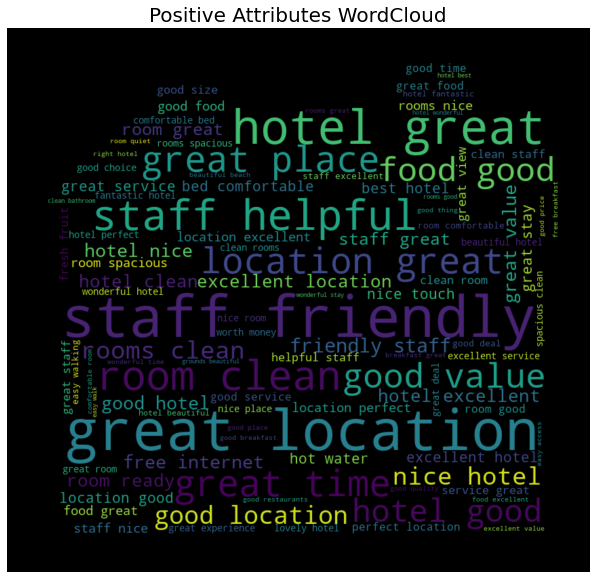

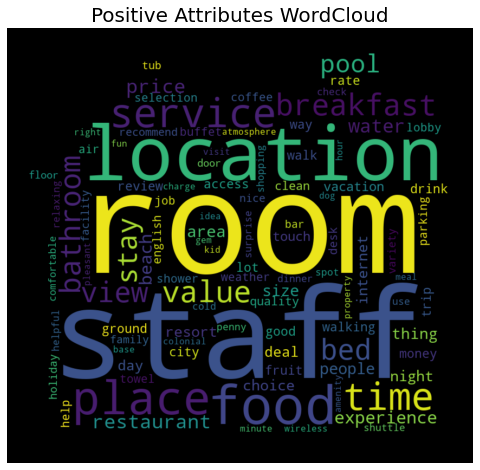

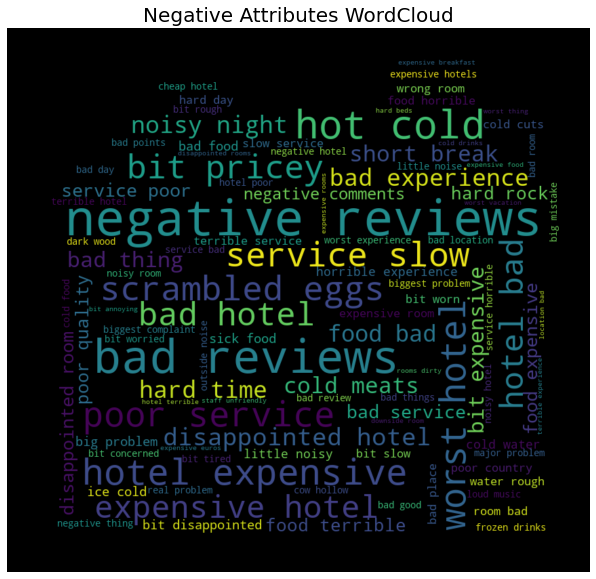

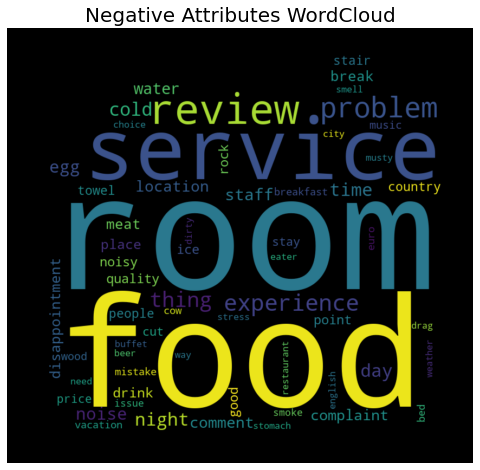

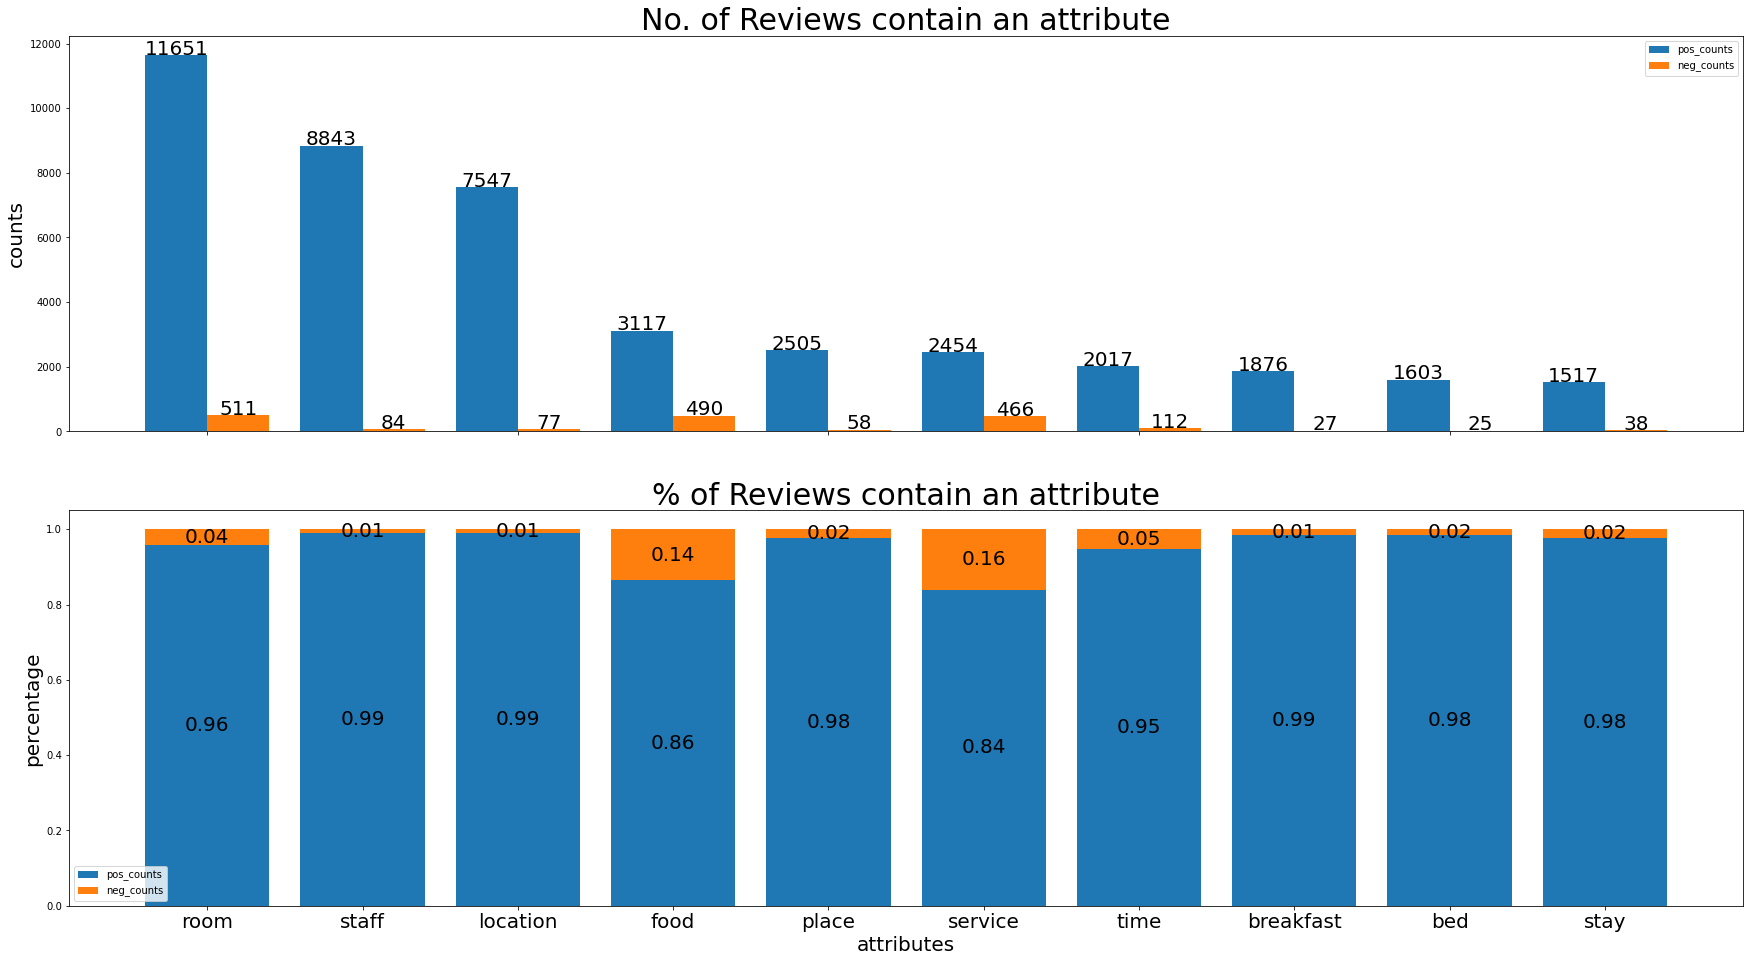

In [77]:
main(data, 'Review')

In [ ]:
# clean(data, col_name), -- data
#vector(data_col, ngram_range=(2,2), max_features=10000), -- count_vect_df, word_list
#pos_neg_comment(word_list), -- pos_comment, neg_comment
#pos_neg_attributes(pos_comment, neg_comment), -- pos_attributes, pos_attributes_noun, neg_attributes, neg_attributes_noun
#pos_neg_attributes_df(count_vect_df, pos_attributes, pos_attributes_noun, neg_attributes, neg_attributes_noun), 
#                                                                                          -- pos_df, pos_dt, neg_df, neg_dt
#pos_neg_attributes_noun(pos_df, neg_df), -- pos_attributes_noun_df, neg_attributes_noun_df
#pos_neg_compare(pos_attributes_noun_df, neg_attributes_noun_df), -- pos_neg_compare
#pos_attributes_wordcloud(pos_dt, pos_attributes_noun_df), -- plot wordcloud
#neg_attributes_wordcloud(neg_dt, neg_attributes_noun_df), -- plot wordcloud
#plot_pos_neg_attributes_count(pos_neg_compare), -- count and bar plot